# model 3-4:近距離の点をクラスター化するモデル

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean as euc
import collections
import operator
import random
import bisect
from itertools import chain
from scipy.optimize import leastsq

In [2]:
def uniq_list(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if x not in seen and not seen_add(x)]

def accumulate(iterable, func=operator.add):
    """Return running totals
    
    Usage:
    accumulate([1,2,3,4,5]) --> 1 3 6 10 15
    accumulate([1,2,3,4,5], operator.mul) --> 1 2 6 24 120
    """
    it = iter(iterable)
    total = next(it)
    yield total
    for element in it:
        total = func(total, element)
        yield total

def weighted_choice(d):
    choices, weights = zip(*d)
    cumdist = list(accumulate(weights))
    x = random.random() * cumdist[-1]
    return choices[bisect.bisect(cumdist, x)]

class Person:
    
    def __init__(self, master, id, ideas, w):
        """Initialize argmunets.
        
        Keyword arguments:
        master    : Master class (call from "Meeting")
        self.id   : Id for each person [0, 1, ..., N-1]
        self.ideas: ideas in space [0,1] × [0,1]
        self.w    : probability weight for the person to speak
        """
        self.id = id
        self.ideas = ideas
        self.w = w
        # add_ideas : place, tag : (x, y), [person_id, cluster_id]
        master.ideas += [[(i1, i2), [self.id, 0, self.w]] for i1, i2 in self.ideas]


class Cluster:
    
    def __init__(self, ideas, r):
        """make cluster with self.r
        
        cluster_link:        
        """
        self.ideas = ideas
        self.r = r
        self.l = 0
        self.cluster_link = []
        self.clustering()
        
    def clustering(self):
        self.cell_num = int(1./self.r)
        lr = 1./self.cell_num
        
        self.cell = dict() # key: (cellx,celly), value: list of ids
        self.rcell = []
        for i, idea in enumerate(self.ideas):
            cellx = int(idea[0][0]/lr)
            celly = int(idea[0][1]/lr)
            if self.cell.has_key((cellx, celly)):
                self.cell[(cellx, celly)] += [i]
            else:
                self.cell[(cellx, celly)] = [i]
            self.rcell.append((cellx, celly))
        num = 1
        for i in range(len(self.ideas)):
            num += self.find_nearest(i, num)
        return self.cluster_link

    def find_nearest(self, idea_id, num):
        """find nearest idea

        idea_id: index in self.ideas
        """
        cx, cy = self.rcell[idea_id]
        place = self.ideas[idea_id][0]
        CX = uniq_list([max(0, cx - 1), cx, min(cx + 1, self.cell_num - 1)])
        CY = uniq_list([max(0, cy - 1), cy, min(cy + 1, self.cell_num - 1)])
        tmp = [self.cell[(i, j)] for i in CX for j in CY if self.cell.has_key((i, j))]
        tmp = list(chain.from_iterable(tmp))
        tmp.remove(idea_id)
        if len(tmp) == 0:
            self.ideas[idea_id][1][1] = num
            return 1
        
        nearest = []
        cid = [num]
        for k in tmp:
            if euc(self.ideas[k][0], place) > self.r:
                continue
            nearest.append(k)
            prenum = self.ideas[k][1][1]
            if prenum == 0:
                cid.append(num)
                self.cluster_link.append((idea_id, k))
            elif prenum < num:
                cid.append(prenum)
                if not (k, idea_id) in self.cluster_link:
                    self.cluster_link.append((idea_id, k))
        self.l += len(nearest)
        cluster_id = min(cid)
        if cluster_id < num:
            ans = 0
        else:
            ans = 1
        self.ideas[idea_id][1][1] = cluster_id
        for i in nearest:
            self.ideas[i][1][1] = cluster_id
        cid.remove(num)
        if len(cid) == 0:
            return ans
        cid.remove(cluster_id)
        if len(cid) == 0:
            return ans
        for i in cid:
            for x in self.ideas:
                if x[1][1] == i:
                    x[1][1] = cluster_id
        return ans

        
class Meeting:
    
    def __init__(self, K, N, S=20, r=0.06, draw=True):
        self.K = K
        self.N = N
        self.S = S
        self.r = r
        self.ideas = []
        self.minutes = []
        self.ave_l = 0
        self.draw = draw
        
    def gather_people(self, ideass=None, weights=None):
        """Gather participants.
        
        Keyword arguments:
        ideas  : list of ideas for each person
               ex) [((0.3,0.1),(0.2,0.5)), ((0.5,0.6))] when N = 2
        weights: list of weights for the probability of the person to speak
        """
        if not ideass:
            x = np.random.rand(self.N, self.S*2)
            ideass = []
            for _x in x:
                ideass.append([(i,j) for i,j in zip(_x[::2], _x[1::2])])
        if not weights:
            weights = [1.] * self.N
        for i, ideas, w in zip(range(self.N), ideass, weights):
            Person(self, i, ideas, w)

    def init(self):
        self.gather_people()
        cluster = Cluster(self.ideas, self.r)
        self.cluster_link = cluster.cluster_link
        self.ave_l = cluster.l/float(len(self.ideas))
        if self.draw:
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
            self.fig = plt.figure(figsize=(9, 9))
            self.ax = self.fig.add_subplot(1, 1, 1)
            self.labels = []
            self.s1 = []
            for idea, tag in self.ideas:
                x = idea[0]
                y = idea[1]
                s = self.ax.scatter(x, y,
                                    c=colors[tag[0]%len(colors)],
                                    alpha=0.2)
                self.s1.append(s)
            data = []
            for link in self.cluster_link:
                ix = self.ideas[link[0]][0][0]
                iy = self.ideas[link[0]][0][1]
                jx = self.ideas[link[1]][0][0]
                jy = self.ideas[link[1]][0][1]
                data += [(ix, jx), (iy, jy), 'k']
            self.ax.plot(*data, alpha=0.5)
            
    def progress(self):
        self.init()
        preidea = self.ideas[np.random.choice(range(len(self.ideas)))]
        self.minutes.append(preidea)
        l = list(self.ideas)
        self.k = 1

        while self.k < self.K + 1:
            
            # remove ideas in the same cluster
            l = [idea for idea in l if idea[1][1] != preidea[1][1]]

            # if no one can speak: meeting ends.
            if len(l) == 0:
                break

            # confirm cluster id which is nearest from the preidea
            distance = [(euc(preidea[0], i[0]), i) for i in l]
            minclusterid = min(distance)[1][1][1]
            
            # gather ideas in the cluster
            tmp = [idea for idea in l if idea[1][1] == minclusterid]
            d = dict()
            for t in tmp:
                d[t[1][0]] = d.get(t[1][0], 0) + t[1][2]
            d = [(k, v) for k, v in d.items()]
            # chose whose ideas to be chosed from the cluster
            whois = weighted_choice(d)
            
            # gather ideas
            who = [idea for idea in tmp if idea[1][0] == whois]
            p = [(idea, idea[1][2]) for idea in who]
            # chose the next idea from the id is "whois"
            idea = weighted_choice(p)

            self.minutes.append(idea)
            preidea = idea
            self.callback()
            self.k += 1
        self.after()

    def callback(self):
        if self.draw:
            ix = self.minutes[-2][0][0]
            iy = self.minutes[-2][0][1]
            jx = self.minutes[-1][0][0]
            jy = self.minutes[-1][0][1]
            l1 = self.ax.plot([ix, jx], [iy, jy], color='b', alpha=0.5)
            self.ax.text((ix+jx)/2, (iy+jy)/2, self.k)
        else:
            pass

    def after(self):
        if self.draw:
            plt.show()
        else:
            pass

閾値$r$を変えたときに意見の総数に対するクラスターの数との関係。横軸$r$、縦軸$1- (\text{クラスターの数})/(\text{意見の総数})$の通常のプロット(上段)と両対数プロット(下段)。

In [13]:
trial = 100

r = np.logspace(-2, np.log10(0.2), num=50)
phi1 = []
for _r in r:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, N=6, r=_r, draw=False)
        meeting.init()
        _phi += len(uniq_list([x[1][1] for x in meeting.ideas]))/float(len(meeting.ideas))
    phi1.append(1 - _phi/trial)

In [4]:
def myplot1(x, y, xfit=np.array([]), yfit=np.array([]), param=None,
            scale=['linear', 'linear', 'log', 'log']):
    """my plot function
    
    x: {'label_x', xdata}
    y: {'label_y', ydata}
    param: {'a': 10, 'b': 20}
    """
    if param:
        s = [r'$%s = %f$' % (k, v) for k, v in param.items()]
        label = s[0]
        for _s in s[1:]:
            label += ", " + _s
    label_x, xdata = x.items()[0]
    label_y, ydata = y.items()[0]
    fig = plt.figure(figsize=(8, 12))
    ax1 = fig.add_subplot(211)

    ax1.plot(xdata, ydata)
    if len(xfit):
        ax1.plot(xfit, yfit, label=label)
        ax1.legend(loc='best')
    ax1.set_xlabel(label_x)
    ax1.set_ylabel(label_y)
    ax1.set_xscale(scale[0])
    ax1.set_yscale(scale[1])
    
    ax2 = fig.add_subplot(212)
    ax2.plot(xdata, ydata)
    if len(xfit):
        ax2.plot(xfit, yfit, label=label)
        ax2.legend(loc='best')
    ax2.set_xlabel(label_x)
    ax2.set_ylabel(label_y)
    ax2.set_xscale(scale[2])
    ax2.set_yscale(scale[3])
    plt.show()

通常のプロット

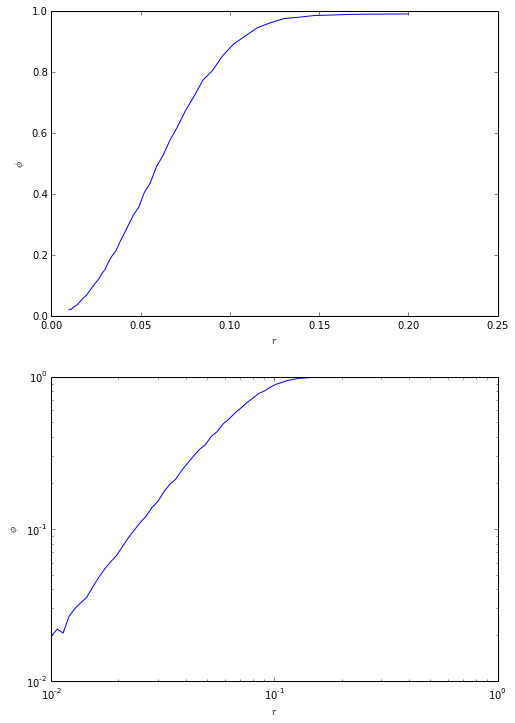

In [18]:
myplot1({r'$r$': r}, {r'$\phi$': phi1})

フィッティング用関数

In [33]:
def myfit(fit_func, parameter, x, y, xmin, xmax):
    """my fitting and plotting function.
    
    fit_func: function (parameter(type:list), x) 
    parameter: list of tuples: [('param1', param1), ('param2', param2), ...]
    x, y: dict
    xmin, xmax: float
    """
    xkey, xdata = x.items()[0]
    ykey, ydata = y.items()[0]

    def fit(parameter, x, y):
        return y - fit_func(parameter, x)

    # use x : xmin < x < xmax
    i = 0
    while xdata[i] < xmin:
        i += 1
    imin, imax = i, i
    while xdata[i] < xmax:
        i += 1
    imax = i - 1

    paramdata = [b for a, b in parameter]
    paramkey = [a for a, b in parameter]
    res = leastsq(fit, paramdata, args=(xdata[imin:imax], ydata[imin:imax]))
    for p in res[0]:
        print xkey + ": " + str(p)
    fitted = fit_func(res[0], xdata[imin:imax])

    fittedparam = dict([(k, v) for k, v in zip(paramkey, res[0])])
    myplot1(x, y, xdata[imin:imax], fitted, param=fittedparam)

$\phi(r) = 10^{b}r^{a}$として最小2乗法でフィッティング

$r$: 1.73018673432
$r$: 1.81957023866


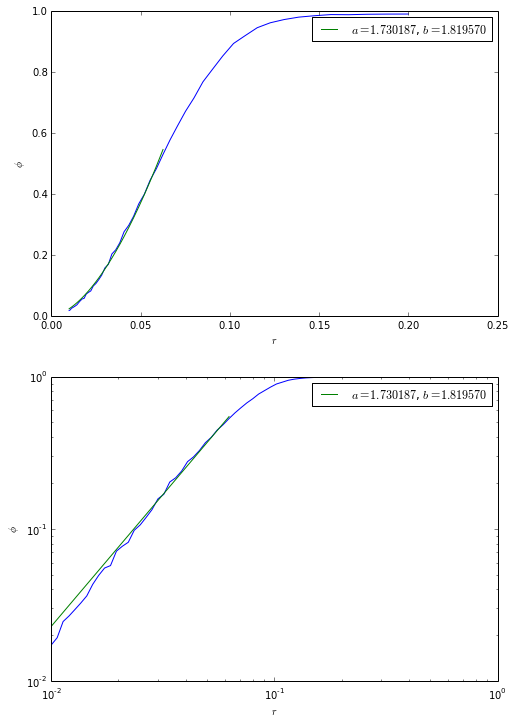

In [34]:
param = [('a', 1.5), ('b', 0.)]
xmin, xmax = 0., 0.07
x = {r'$r$': r}
y = {r'$\phi$': phi1}
def fit_func(parameter, x):
    a = parameter[0]
    b = parameter[1]
    return np.power(x, a)*np.power(10, b)
myfit(fit_func, param, x, y, xmin, xmax)

両変数を対数にした状態で直線としてフィットしてみる。得られたパラメータによるフィッティング関数のプロットは、元の状態に戻してから行う。後に示す直接べき関数として求めた場合に比べて、$r$の小さい領域での直線の傾きがよく合っているように見える。

傾き: 1.86089133868
切片: 2.00299872509


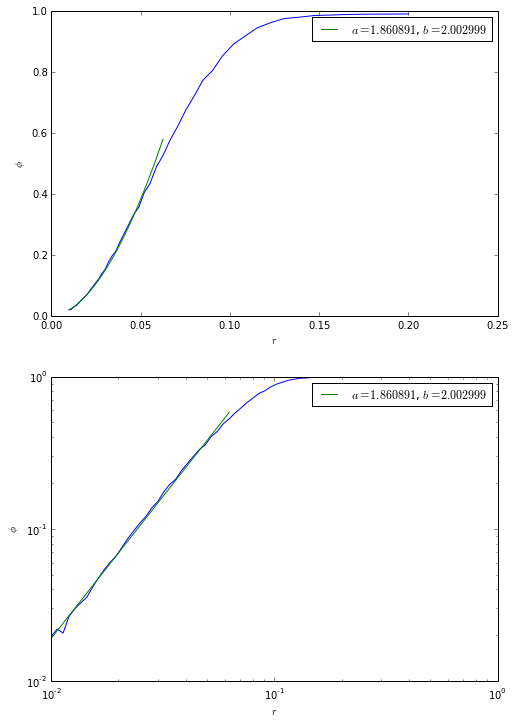

In [19]:
a = 1.5
b = 0.
param = [a, b]
rmin, rmax = 0., 0.07

def fit_func(parameter, x):
    a = parameter[0]
    b = parameter[1]
    return a*np.log10(x) + b

def fit(parameter, x, y):
    return np.log10(y) - fit_func(parameter, x)

i = 0
while r[i] < rmin:
    i += 1
imin, imax = i, i
while r[i] < rmax:
    i += 1
imax = i - 1

res = leastsq(fit, param, args=(r[imin:imax], phi1[imin:imax]))
print u"傾き: " + str(res[0][0])
print u"切片: " + str(res[0][1])
R1 = np.power(10, fit_func(res[0], r[imin:imax]))

myplot1({r'$r$': r}, {r'$\phi$': phi1}, r[imin:imax], R1, param={'a': res[0][0], 'b': res[0][1]})

S字型の曲線であるので、
$$\phi (r) = 1 - \exp \left[ -  \left( \frac{r}{\omega} \right)^{a} \right]$$

としてパラメータ$\omega$に関して最小2乗法でフィッティングを行った場合。

omega: 0.0710580799788
a: 2.09805559422


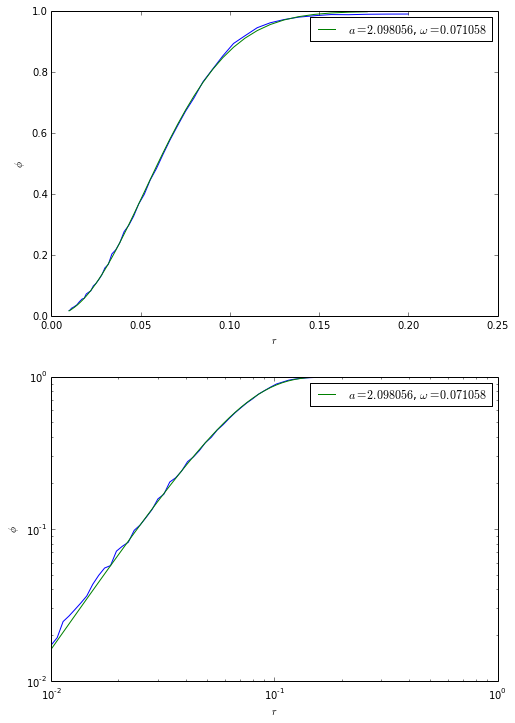

In [16]:
omega = 0.06
a = 2.0
param = [omega, a]
rmin, rmax = 0.01, 0.2

def fit_func(parameter, x):
    omega = parameter[0]
    a = parameter[1]
    return 1 - np.exp(-(x/omega)**a)

def fit(parameter, x, y):
    return y - fit_func(parameter, x)

i = 0
while r[i] < rmin:
    i += 1
imin, imax = i, i
while r[i] < rmax:
    i += 1
imax = i - 1

res = leastsq(fit, param, args=(r[imin:imax], phi1[imin:imax]))
print u"omega: " + str(res[0][0])
print u"a: " + str(res[0][1])
R3 = fit_func(res[0], r[imin:imax])

myplot1({r'$r$': r}, {r'$\phi$': phi1}, r[imin:imax], R3, param={'\omega': res[0][0], 'a': res[0][1]})

### $r$を固定して$N$を変更したときのクラスター数と点の総数の間の関係

横軸を$X_{i}$の数$N$、縦軸を$1-(\text{クラスタ数}/\text{点の総数})$としたときのグラフを書いてみる。

In [25]:
trial = 100

N = np.arange(1, 20)
phi6 = []
for _N in N:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, N=_N, r=0.07, draw=False)
        meeting.init()
        _phi += len(uniq_list([x[1][1] for x in meeting.ideas]))/float(len(meeting.ideas))
    phi6.append(1 - _phi/trial)

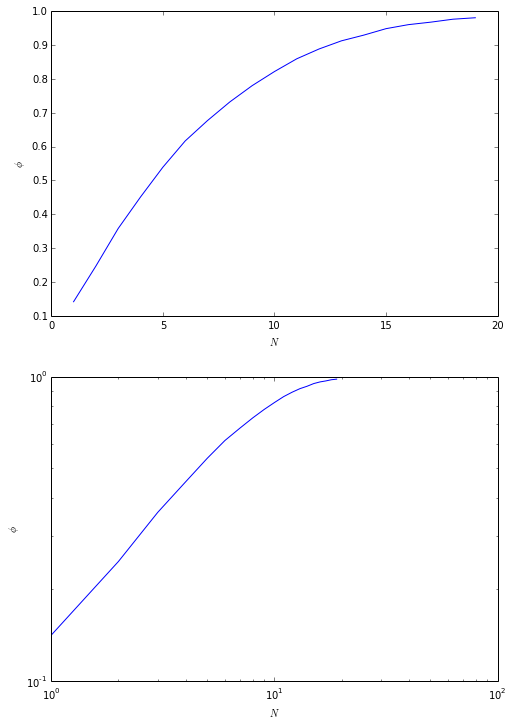

In [26]:
myplot1({r'$N$': N}, {r'$\phi$': phi6})

このとき、意見の総数と参加者の数、一人あたりの意見の数の間には比例の関係が成り立っており、この数のみに依存して、どちらを変えるかは問題ではない。したがって、より刻みを多く取ることのできる一人あたりの意見の数$S$を変えて計算した場合を見てみることにする。

In [3]:
trial = 100

S = np.arange(10, 70)
phi7 = []
for _S in S:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, S=_S, N=6, r=0.07, draw=False)
        meeting.init()
        _phi += len(uniq_list([x[1][1] for x in meeting.ideas]))/float(len(meeting.ideas))
    phi7.append(1 - _phi/trial)

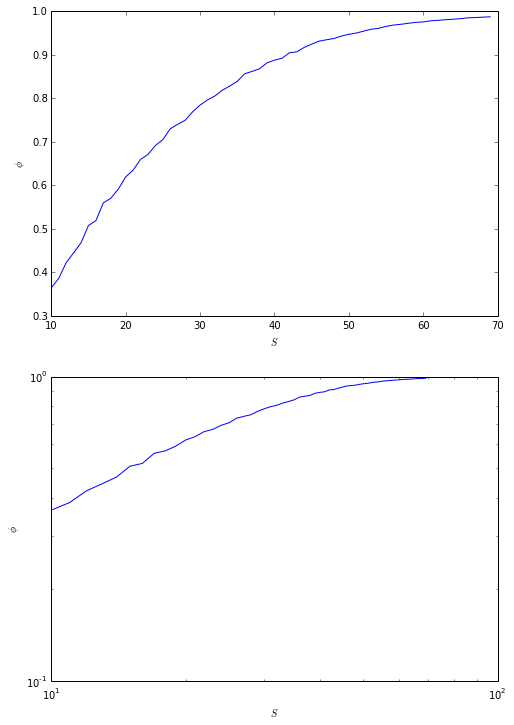

In [5]:
myplot1({r'$S$': S}, {r'$\phi$': phi7})

グラフの形から、

$$\phi(S) = 1- \exp\left[- \left( \frac{S}{\omega} \right)^{a}\right]$$

であるとしてフィッティングを行ってみる。

omega: 20.6143107436
a: 1.17886589316


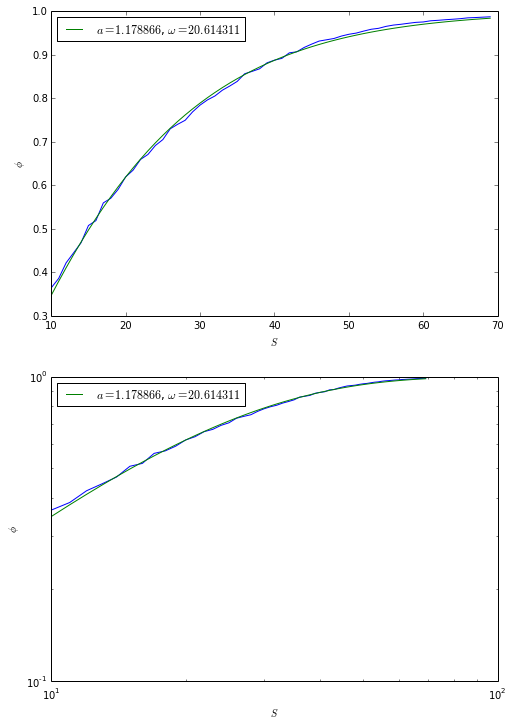

In [12]:
omega = 20.
a = 1.
param = [omega, a]

def fit_func(parameter, x):
    omega = parameter[0]
    a = parameter[1]
    return 1. - np.exp(-(x/omega)**a)

def fit(parameter, x, y):
    return y - fit_func(parameter, x)

res = leastsq(fit, param, args=(S, phi7))
print u"omega: " + str(res[0][0])
print u"a: " + str(res[0][1])
R5 = fit_func(res[0], S)

myplot1({r'$S$': S}, {r'$\phi$': phi7}, S, R5, param={r'\omega': res[0][0], r'a': res[0][1]})

閾値$r$を決めたときに、領域$\Omega$内の任意の点を一様に選んだとき、その中に点が存在する確率の期待値は、解析的計算によって

$$p'(r) = \frac{1}{2}r^{4} -\frac{8}{3}r^{3} + \pi r^{2}$$

$r$を定めたとき、すべての点の個数が$M$個であるとすると、一つの点の点がもつ次数の期待値$l$は
$$l = p'(r)(M-1) = \left( \frac{1}{2}r^{4} -\frac{8}{3}r^{3} + \pi r^{2} \right)(M-1)$$
となる。これを実際のシミュレーションの結果と照らして確かめる。

In [35]:
trial = 100

r = np.linspace(0.01, 0.5, num=50)
phi3 = []
for _r in r:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, N=6, r=_r, draw=False)
        meeting.init()
        _phi += meeting.ave_l
    phi3.append(_phi/trial)

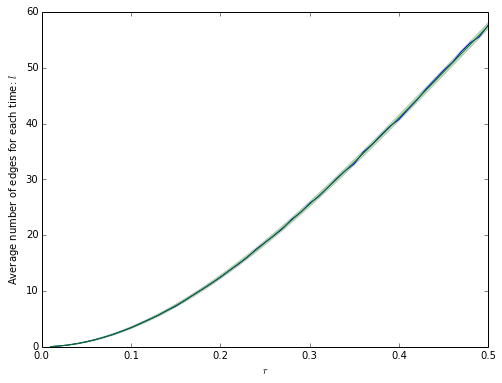

In [37]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

r = np.linspace(0.01, 0.5, num=50)
def func(x):
    return (1./2*x**4 - 8/3.*x**3 + np.pi*x**2)*(120-1)
y = func(r)
def func2(x):
    return np.sqrt((-0.25*x**8 + 8/3.*x**7 - (64/9.+np.pi)*x**6 + 16/3.*np.pi*x**5
                   + (0.5-np.pi**2)*x**4 - 8/3.*x**3 + np.pi*x**2)*(120-1)/(trial))

delta = func2(r)
y1 = y + delta
y2 = y - delta
y3 = np.zeros(50)
y3[y2>0] = y2[y2>0]
ax.fill_between(r, y1, y3, facecolor='green', alpha=0.2)
ax.plot(r, phi3)
ax.plot(r, y)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r"Average number of edges for each time: $l$")
plt.show()